# Evrişimli Sinir Ağları (CNN) ile Beyin Tümörü Sınıflandırması

## 1) İş Problemini Anlamak

<p>Burada amaç beyin MRI görüntülerinin maksimum doğrulukla sağlıklı beyin, iyi huylu tümör, kötü huylu tümör ve hipofiz bezi tümörü olarak sınıflandırılmasıdır.</p>

## 2) Veriyi Anlamak

### 2.1) Veri Seti Hikayesi
<p>Bu proje kapsamında kullanacağımız veri seti Brain Tumor MRI isimli veri setidir.

Veri seti 4 farklı sınıftan oluşmaktadır. Veri seti sağlıklı beyin, iyi huylu beyin tümörü, kötü huylu beyin tümörü ve hipofiz bezi tümörü olmak üzere toplam 5712 adet eğitim görüntüsü 1311 adet ise test görüntüsü bulundurmaktadır.</p>

### 2.2) Gerekli Olan Kütüphanelerin Yüklenmesi

In [1]:
pip install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=27bbe01b3bd8ec1d5018383c46dde1a7c1894ae095e18928b2b2ba3e5f146442
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install hashlib

ERROR: Ignored the following yanked versions: 20081119
ERROR: Could not find a version that satisfies the requirement hashlib (from versions: none)
ERROR: No matching distribution found for hashlib
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths
import hashlib

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 2.3) Veri Setlerinin Okunması

In [4]:
# Veri setindeki görüntülerin dönüştürüleceği boyut.
target_size = (200, 200)

# Veri setindeki görünütlere ait etiketlerin sayısallaştırılması için kullanılacak sözlük yapısı.
labels_map = {"notumor": 0, "glioma": 1, "meningioma": 2, "pituitary": 3}

In [5]:
def load_datasets(path):
    labels = []
    x=[]

    # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
    image_paths = sorted(list(paths.list_images(path)))
    
    for image_path in image_paths:
        # Belirtilen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
        img = cv.imread(image_path)

        # Okunan görüntüler başlangıçta belirtilen target_size'a göre yeniden ölçeklendirilir.
        img = cv.resize(img, target_size)

        # Ölçeklendirilen görüntüler x listesine eklenir.
        x.append(img)

        # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı label'ı ifade eder.
        label = image_path.split("/")[-2]
        
        # Yakalanan labelların sayısal değer karşılıklarının olduğu labels_map sözlüğü içerisinden gönderilen key değerine karşılık value değeri alınarak label oluşturulur.
        labels.append(labels_map[label])
        
    # Veri seti random bir şekilde karıştırılır.
    x, labels = shuffle(x, labels, random_state=42)

    # Boyut ve sınıf bilgisinin raporlanması
    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

    return x, labels

In [6]:
# Eğitim setinin oluşturulması
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

train_x, train_labels = load_datasets(train_dir)

X boyutu: (5712, 200, 200, 3)
Label sınıf sayısı: 4 Gözlem sayısı: 5712


In [7]:
# Test setinin oluşturulması
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

test_x, test_labels = load_datasets(test_dir)

X boyutu: (1311, 200, 200, 3)
Label sınıf sayısı: 4 Gözlem sayısı: 1311


In [8]:
def find_duplicates_in_dataset(x):
    """
    Görüntü veri seti içerisinde tekrar eden görüntüleri tespit eder.
    
    Parameters:
        x (list or numpy array): Görüntülerin numpy array formatındaki listesi.
    
    Returns:
        duplicates (list): Tekrar eden görüntülerin index çiftlerini içeren liste.
    """
    seen_hashes = {}  # Görüntülerin hash'lerini tutacak bir sözlük
    duplicates = []   # Tekrar eden görüntülerin index çiftlerini tutacak liste

    for idx, img in enumerate(x):
        # Görüntünün hash değerini hesapla
        img_hash = hashlib.md5(img.tobytes()).hexdigest()
        
        # Eğer hash değeri zaten görüldüyse, bu görüntü tekrardır
        if img_hash in seen_hashes:
            duplicates.append((idx, seen_hashes[img_hash]))
        else:
            seen_hashes[img_hash] = idx

    return duplicates

In [9]:
train_duplicates = find_duplicates_in_dataset(train_x)

In [10]:
test_duplicates = find_duplicates_in_dataset(test_x)

In [11]:
def remove_duplicates(x, labels, duplicates):
    """
    Tekrar eden görüntüleri ve bunların etiketlerini kaldırır.

    Parameters:
        x (list): Görüntülerin listesi.
        labels (list): Görüntülere karşılık gelen etiketlerin listesi.
        duplicates (list): Tekrar eden görüntülerin index çiftlerini içeren liste.

    Returns:
        x_filtered (list): Tekrar edenler çıkarıldıktan sonraki görüntüler.
        labels_filtered (list): Tekrar edenler çıkarıldıktan sonraki etiketler.
    """
    # Tekrar eden tüm indeksleri bir küme haline getirelim (her bir çiftteki ilk indeks yeterli)
    duplicate_indices = set([dup[0] for dup in duplicates])

    # Eşsiz görüntü ve etiketleri tutacak listeler
    x_filtered = []
    labels_filtered = []

    # Her indeksi kontrol ederek tekrar edenleri atla
    for idx in range(len(x)):
        if idx not in duplicate_indices:
            x_filtered.append(x[idx])
            labels_filtered.append(labels[idx])

    return x_filtered, labels_filtered

In [12]:
train_x, train_labels = remove_duplicates(train_x, train_labels, train_duplicates)

In [13]:
test_x, test_labels = remove_duplicates(test_x, test_labels, test_duplicates)

In [14]:
# Çıkış katmanında kullanılacak (Toplam sınıf saysı)
total_classes = len(np.unique(train_labels))

In [15]:
numbers_map = {value: key for key, value in labels_map.items()}
numbers_map

{0: 'notumor', 1: 'glioma', 2: 'meningioma', 3: 'pituitary'}

### 2.4) Veri Setinden Örnek Görseller

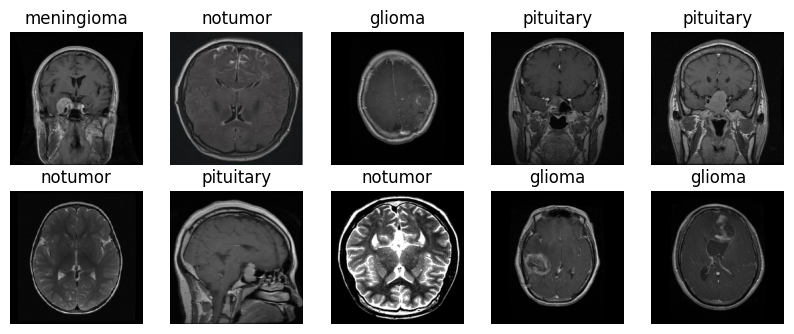

In [16]:
# İlk 10 görsel
plt.figure(figsize=(10, 10))
for i in range(0, 10):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(numbers_map[train_labels[i]])
    plt.axis("off")

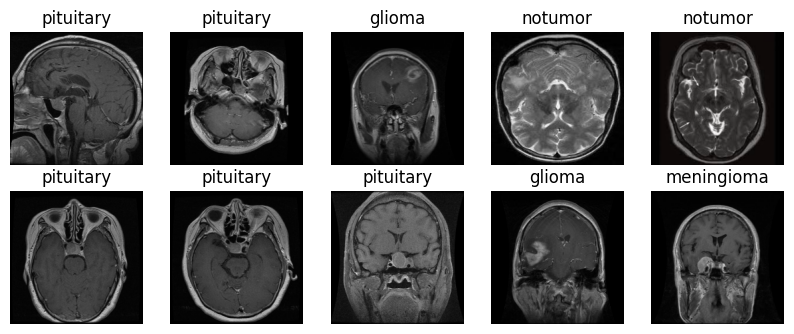

In [17]:
# Son 10 görsel
plt.figure(figsize=(10, 10))
for i in range(0, 10):
    ax = plt.subplot(5, 5, 10-i)
    plt.imshow(train_x[-i])
    plt.title(numbers_map[train_labels[-i]])
    plt.axis("off")

### 2.5) Veri Setlerindeki Sınıf Dağılımları

In [18]:
train_l, train_f = np.unique(train_labels, return_counts=True)
test_l, test_f = np.unique(test_labels, return_counts=True)

In [19]:
train_labels_freq = pd.DataFrame({"Labels": list(labels_map.keys()), "Freq": train_f})
test_labels_freq = pd.DataFrame({"Labels": list(labels_map.keys()), "Freq": test_f})

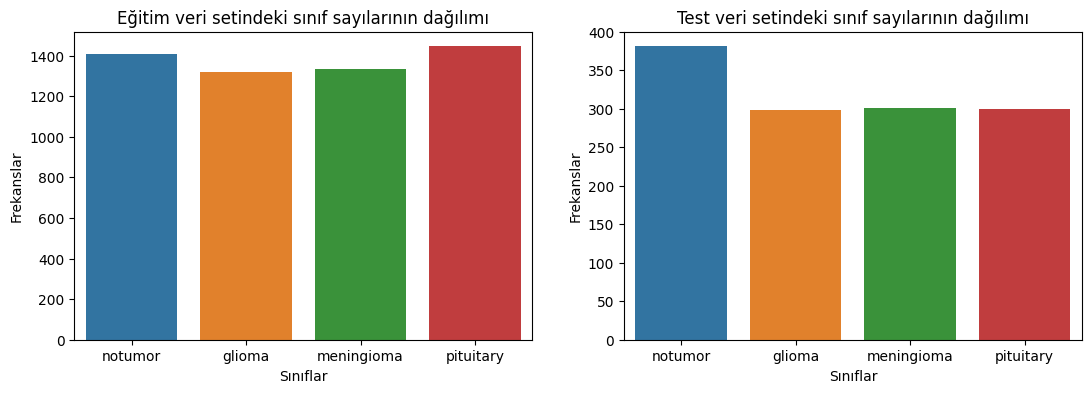

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))
sns.barplot(x=train_labels_freq["Labels"], y=train_labels_freq["Freq"], ax=ax[0])
ax[0].set_title("Eğitim veri setindeki sınıf sayılarının dağılımı")
ax[0].set_xlabel("Sınıflar")
ax[0].set_ylabel("Frekanslar")

sns.barplot(x=test_labels_freq["Labels"], y=test_labels_freq["Freq"], ax=ax[1])
ax[1].set_title("Test veri setindeki sınıf sayılarının dağılımı")
ax[1].set_xlabel("Sınıflar")
ax[1].set_ylabel("Frekanslar")
plt.show()

## 3) Veriyi Hazırlama

In [21]:
train_x = np.array(train_x)
train_labels = np.array(train_labels)

test_x = np.array(test_x)
test_labels = np.array(test_labels)

In [22]:
tr_x, val_x, tr_labels, val_labels = train_test_split(train_x, train_labels, test_size=0.2, random_state=13)

In [23]:
tr_x = tr_x / 255.0
val_x = val_x / 255.0
test_x = test_x / 255.0

In [24]:
# Etiketleri one-hot encode etme işlemi
tr_labels = to_categorical(tr_labels, num_classes=total_classes)
val_labels = to_categorical(val_labels, num_classes=total_classes)
test_labels = to_categorical(test_labels, num_classes=total_classes) 

## 4) Modelleme

### CNN Modeli Kurulum Amasıp>
<ol>
    <li><strong>Sequential (Sıralı Model):</strong> Modelin katmanlarının sıralı bir şekilde tanımlandığı yapı.</li>
    <li><strong>Evrişim Katmanı:</strong> Görüntülerden özellik çıkarma aşaması.<i>/l
    <li><strong>Havuzlama Katmanı:</strong> Görüntünün özelliklerini kaybetmeden boyutunu küçültmek için kullanılır.</li>
    <li><strong>Flatten Katmanı:</strong> Görüntü matrisini tek boyuta indirmek için kullanılır.</li>
    <li><strong>Dense Katmanı:</strong> Katmanlar arasında nöron veya düğümlerin geçişlerini sağlar.</li>
    <li><strong>Dropout Katmanı:</strong> Aşırı öğrenmenin önüne geçmek için kullanılır.</li>
    <li><strong>Çıkış Katmanı:</strong> Modelin tahmin sonuçlarını verdiği son katma</li>i<
o/ol>

In [25]:
model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(200,200,3)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')

])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 4.1) Model Özeti

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,083,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,916 (4.26 MB)

 Trainable params: 1,116,916 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2) Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

In [27]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [28]:
callbacks = [EarlyStopping(monitor="val_loss", 
                           patience=3, 
                           mode="min",
                           min_delta=0.1,
                           verbose=1,
                           restore_best_weights=True), 
             ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.5, 
                               patience=2)]

In [29]:
# from tensorflow.keras.callbacks import Callback

# class CustomEarlyStopping(Callback):
#     def __init__(self, threshold=0.05, patience=2):
#         super(CustomEarlyStopping, self).__init__()
#         self.threshold = threshold
#         self.patience = patience
#         self.wait = 0  # Bekleme sayacı

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         train_loss = logs.get('loss')
#         val_loss = logs.get('val_loss')

#         # Eğer train_loss veya val_loss yoksa callback çalışmaz
#         if train_loss is not None and val_loss is not None:
#             # Fark belirli eşiği geçerse kontrol et
#             if val_loss > train_loss + self.threshold:
#                 self.wait += 1
#                 print(f"Epoch {epoch + 1}: Validation loss {val_loss:.4f} is greater than Train loss {train_loss:.4f} by more than {self.threshold}. Patience: {self.wait}/{self.patience}")
#                 if self.wait >= self.patience:
#                     print(f"Stopping training early at epoch {epoch + 1} due to overfitting.")
#                     self.model.stop_training = True
#             else:
#                 # Eğer fark eşiği aşmazsa beklemeyi sıfırla
#                 self.wait = 0

In [30]:
# custom_early_stopping = CustomEarlyStopping(threshold=0.05, patience=3)

In [31]:
# callbacks = [custom_early_stopping, 
#              ReduceLROnPlateau(monitor='val_loss', 
#                                factor=0.5, 
#                                patience=2)]

### 4.3) Modelin Eğitilmesi

In [32]:
history = model.fit(tr_x,  # numpy array'ler doğrudan listeye dönüştürülüyor
                    tr_labels, # Eğitim veri setinin belirtilmesi
                    epochs=15, # Modelin kaç kere eğitileceğinin belirtilmesi
                    validation_data=(val_x, val_labels), # Doğrulama setinin belirtilmesi
                    callbacks=callbacks) # Callbacklerin belirtilmesi

Epoch 1/15


I0000 00:00:1735566040.114333      85 service.cc:145] XLA service 0x7f1290004c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735566040.114387      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/138 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2434 - loss: 1.4171 - precision: 0.1786 - recall: 0.0049

I0000 00:00:1735566045.962323      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.4048 - loss: 1.2149 - precision: 0.5876 - recall: 0.1331 - val_accuracy: 0.7075 - val_loss: 0.6846 - val_precision: 0.7745 - val_recall: 0.6022 - learning_rate: 0.0010
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6812 - loss: 0.7454 - precision: 0.7618 - recall: 0.5682 - val_accuracy: 0.8056 - val_loss: 0.4987 - val_precision: 0.8494 - val_recall: 0.7584 - learning_rate: 0.0010
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7782 - loss: 0.5758 - precision: 0.8243 - recall: 0.7018 - val_accuracy: 0.8547 - val_loss: 0.3930 - val_precision: 0.8759 - val_recall: 0.8401 - learning_rate: 0.0010
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8297 - loss: 0.4487 - precision: 0.8567 - recall: 0.7980 - val_accuracy: 0.8792 - val_loss: 0.3080 - val_precision: 0.8952 - val_recall: 0.8610 - learning_rate: 0.0010
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.860

## 5) Modelin Değerlendirilmesi

### 5.1) Kayıpların ve İlgili Değerlendirme Metriklerinin Görselleştirilmesi

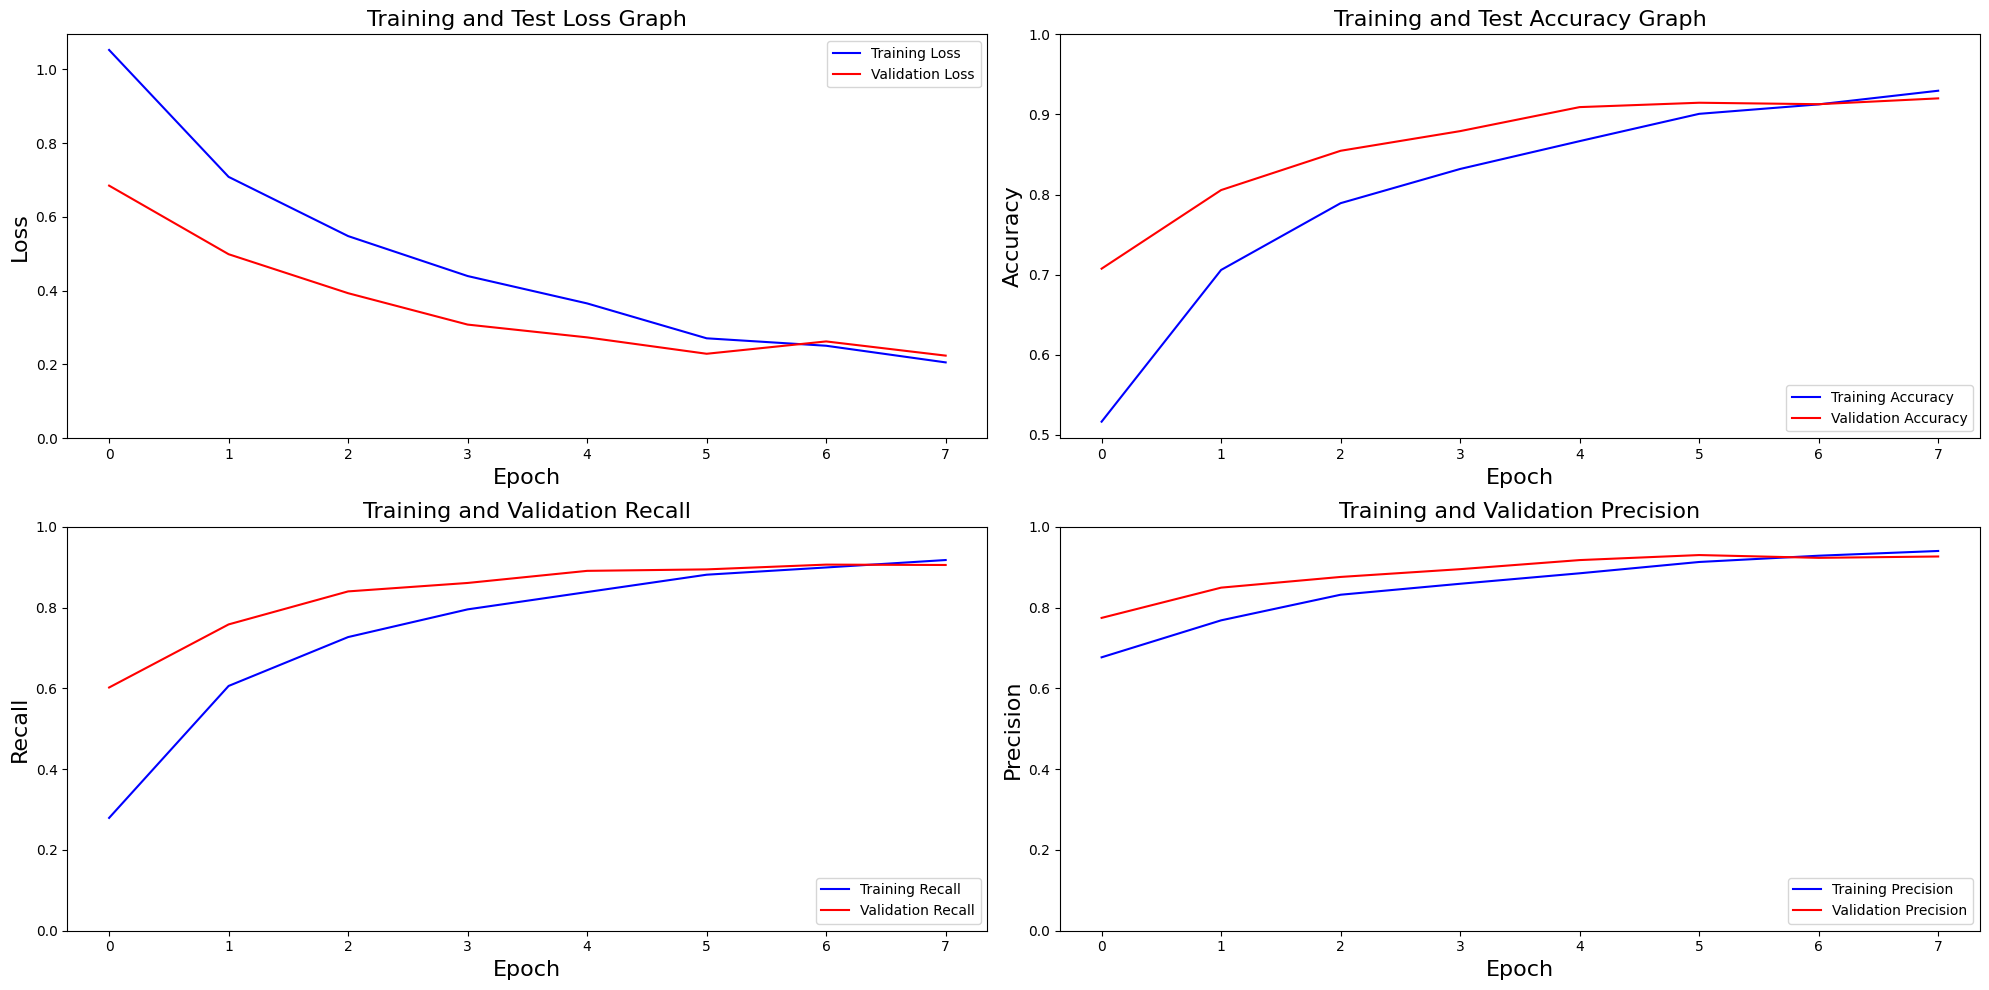

In [33]:
# Loss
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Test Loss Graph", fontsize=16)

# Accuracy
plt.subplot(2,2,2)
plt.plot(history.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Test Accuracy Graph", fontsize=16)


# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history["recall"], color="b", label="Training Recall")
plt.plot(history.history["val_recall"], color="r", label="Validation Recall")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Recall", fontsize=16)
plt.ylim([0, 1])
plt.title("Training and Validation Recall", fontsize=16)

# Precision
plt.subplot(2, 2, 4)
plt.plot(history.history["precision"], color="b", label="Training Precision")
plt.plot(history.history["val_precision"], color="r", label="Validation Precision")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.ylim([0, 1])
plt.title("Training and Validation Precision", fontsize=16)


# Boş alan düzenleme
plt.tight_layout()
plt.show()

### 5.2) Modelin Test Verisi Üzerinden Değerlendirilmesi

In [34]:
test_score = model.evaluate(x=test_x, y=test_labels)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8541 - loss: 0.3704 - precision: 0.8662 - recall: 0.8350


In [35]:
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test Precision: ", test_score[2])
print("Test Recall: ", test_score[3])

Test Loss:  0.3395445942878723
Test Accuracy:  0.8657299280166626
Test Precision:  0.8493364453315735
Test Recall:  0.8760064244270325


### 5.3) Test Veri Setinden Gerçek Etiketler ile Model Tahminlerinin Toplanması (ROC-AUC Curve, CM, CR Analizleri için)

In [36]:
y_true = []
y_pred_probs = []

# Model tahminlerini al
y_pred_probs = model.predict(test_x)

# Gerçek etiketleri listeye ekle
y_true = test_labels

# Eğer numpy array'e dönüştürme gerekiyorsa
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [37]:
y_true

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [38]:
y_pred_probs

array([[6.6912093e-04, 8.4202125e-04, 6.0392139e-03, 9.9244964e-01],
       [9.9420280e-04, 1.0145463e-04, 9.3690706e-03, 9.8953527e-01],
       [9.7298162e-04, 9.0282434e-01, 9.5769137e-02, 4.3355572e-04],
       ...,
       [1.2919971e-03, 1.2332104e-02, 2.8284675e-01, 7.0352912e-01],
       [9.9967974e-01, 1.7960055e-07, 3.1968675e-04, 2.6410447e-07],
       [1.2791617e-04, 7.3371913e-05, 1.1724458e-03, 9.9862635e-01]],
      dtype=float32)

### 5.4) Modelin ROC-AUC Eğrisi ile Değerlendirilmesi

In [39]:
from sklearn.metrics import roc_curve, auc

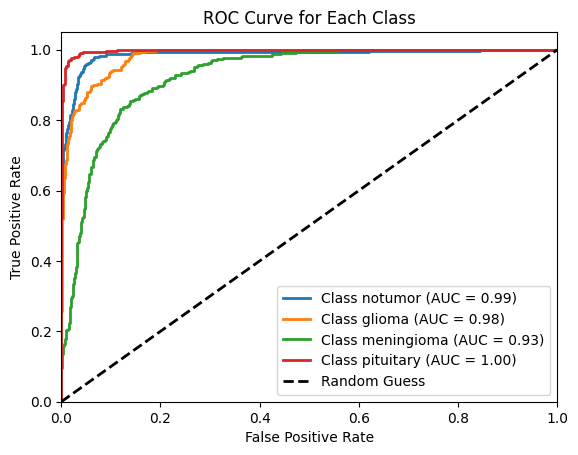

In [40]:
# Sınıf sayısını belirle
num_classes = y_true.shape[1]

# Her sınıf için ROC eğrisi ve AUC hesapla
for i in range(num_classes):
    # Gerçek etiketler ve tahmin olasılıkları
    y_true_class = y_true[:, i]
    y_pred_class = y_pred_probs[:, i]
    
    # ROC eğrisi ve AUC hesaplama
    fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_class)
    roc_auc = auc(fpr, tpr)
    
    # ROC eğrisini çizme
    plt.plot(fpr, tpr, lw=2, label=f'Class {numbers_map[i]} (AUC = {roc_auc:.2f})')

# Rastgele tahmin çizgisi
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

# Grafik düzenleme
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

### 5.4) Modelin Classification Report ile Değerlendirilmesi

In [41]:
# Gerçek sınıfların ve tahmin edilen sınıfların belirlenmesi
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

In [42]:
# Labels sadece sınıf indekslerini içeren bir liste olmalı
labels = [0, 1, 2, 3]

# Sınıf isimleri 'target_names' ile belirtilir
target_names = ["notumor", "glioma", "meningioma", "pituitary"]

# Classification Report'u oluştur
print(classification_report(y_true_classes, y_pred_classes, labels=labels, target_names=target_names))

              precision    recall  f1-score   support

     notumor       0.86      0.98      0.91       381
      glioma       0.86      0.85      0.86       299
  meningioma       0.78      0.64      0.70       301
   pituitary       0.96      0.96      0.96       300

    accuracy                           0.87      1281
   macro avg       0.86      0.86      0.86      1281
weighted avg       0.86      0.87      0.86      1281



### 5.5) Modelin Karmaşıklık Matrisi Üzerinden Değerlendirilmesi

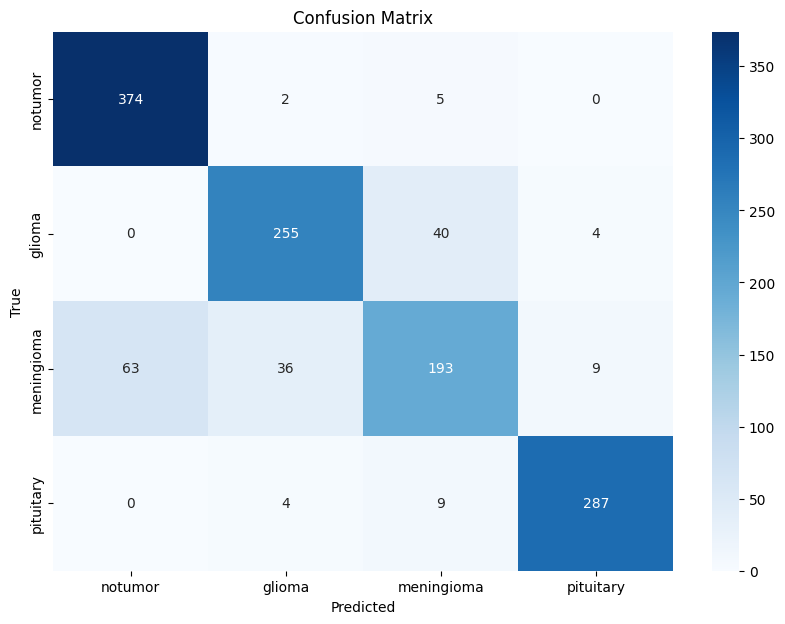

In [43]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', yticklabels=list(labels_map.keys()), xticklabels=list(labels_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 6) Test Veri Setinden Rastgele Örnekler Seçerek Modeli Test Etme

In [44]:
def sample_visualization():
    # Rastgele bir örnek seçmek
    sample_index = np.random.randint(len(test_x))
    x_sample = test_x[sample_index]
    y_sample = test_labels[sample_index]

    # Model tahmini
    y_pred = model.predict(x_sample[np.newaxis, ...])
    predicted_class = np.argmax(y_pred, axis=1)

    # Gerçek sınıf
    true_class = np.argmax(y_sample)

    # Görselleştirme için veriyi dönüştürmek (0-255 arasında piksel değerleri)
    x_sample_visual = x_sample * 255
    x_sample_visual = x_sample_visual.astype('uint8')

    # Görselleştirme
    plt.imshow(x_sample_visual)
    plt.title(f"T: {numbers_map[true_class]} P: {numbers_map[predicted_class[0]]}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


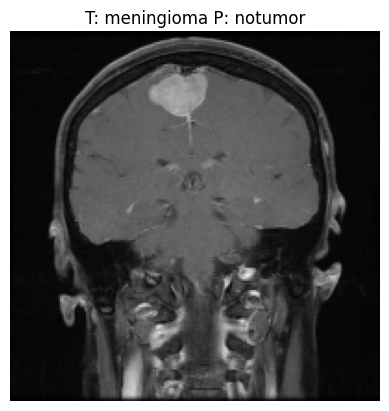

In [45]:
sample_visualization()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


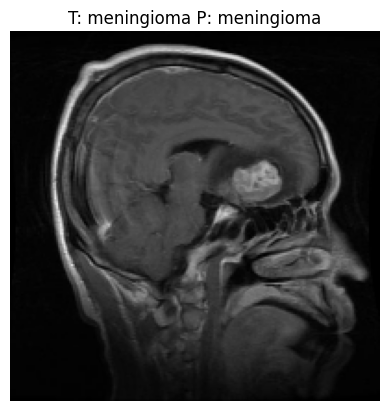

In [46]:
sample_visualization()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


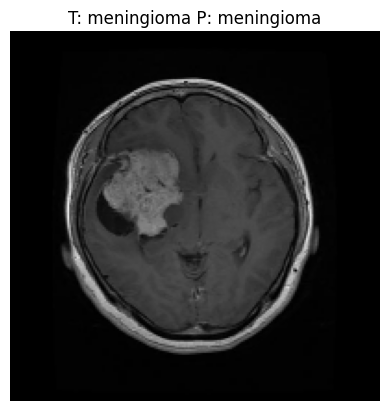

In [47]:
sample_visualization()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


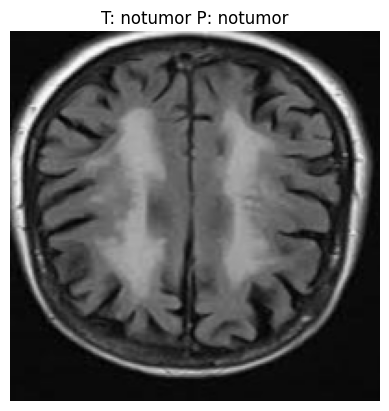

In [48]:
sample_visualization()